# Correlation Attenuation Toolbox - Tutorial

This notebook demonstrates how to use the Correlation Attenuation Toolbox for:

1. **Analyzing existing data** - Compute naive and corrected correlations with confidence intervals
2. **Planning future studies** - Simulate data to determine optimal sample sizes and measurement protocols

## Background

When measuring the correlation between two variables, measurement noise (unreliability) causes the observed correlation to underestimate the true correlation. This is called **attenuation**.

The classical correction formula (Spearman, 1904) is:

$$r_{corrected} = \frac{r_{observed}}{\sqrt{\text{reliability}_X \times \text{reliability}_Y}}$$

This toolbox helps you:
- Estimate reliability from test-retest measurements
- Apply the correction properly
- Quantify uncertainty via bootstrap confidence intervals
- Determine when correction is beneficial via simulation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import toolbox modules
from attenuation_toolbox import (
    # Core analysis
    TaskParameters,
    analyze_correlation,
    analyze_all_pairs,
    summarize_task_statistics,
    compute_reliability,
    
    # Simulation
    simulate_test_retest_data,
    run_simulation,
    run_simulation_grid,
    get_simulation_distributions,
    
    # Visualization
    set_publication_style,
    plot_correlation_heatmaps,
    plot_correlation_histograms,
    plot_rmse_comparison,
    plot_simulation_summary,
    plot_scatter_with_reliability,
)

# Set nice plot defaults
set_publication_style()
#np.random.seed(42)

---

# Part 1: Analyzing Existing Data

Use this workflow when you have collected data with test-retest measurements for multiple tasks.

## 1.1 Data Format

Your data should be organized as a DataFrame where:
- Each **row** is a subject
- Each **column** is a measurement
- Column names follow the pattern: `taskname_repeatN`

In [16]:
# Example: Create synthetic data for demonstration
# In practice, you would load your own data: pd.read_csv('your_data.csv')

# Define task parameters (these would come from your actual measurements)
task1_params = TaskParameters(
    between_var=0.35,   # Variance between subjects (true individual differences)
    within_var=0.015,    # Variance within subjects (measurement noise)
    mean=-0.5,           # Mean value
    name='task1'
)

task2_params = TaskParameters(
    between_var=0.45,
    within_var=0.01,
    mean=2.9,
    name='task2'
)

# Simulate a dataset with 80 subjects, 4 repeats per task, true r=0.6
demo_data = simulate_test_retest_data(
    task1_params, task2_params,
    n_subjects=80,
    n_repeats=4,
    true_correlation=0.5,
    random_state=None
)

print("Data shape:", demo_data.shape)
print("\nColumn names:")
print(demo_data.columns.tolist())
print("\nFirst 5 rows:")
demo_data.head()

Data shape: (80, 12)

Column names:
['task1_true', 'task2_true', 'task1_repeat1', 'task2_repeat1', 'task1_repeat2', 'task2_repeat2', 'task1_repeat3', 'task2_repeat3', 'task1_repeat4', 'task2_repeat4', 'task1_mean', 'task2_mean']

First 5 rows:


,task1_true,task2_true,task1_repeat1,task2_repeat1,task1_repeat2,task2_repeat2,task1_repeat3,task2_repeat3,task1_repeat4,task2_repeat4,task1_mean,task2_mean
0,-1.111740,1.924689,-1.177826,1.956073,-1.151625,1.991952,-1.009945,1.865451,-1.162535,2.022385,-1.125483,1.958965
1,-0.731045,3.386310,-0.729649,3.402317,-0.814613,3.377202,-0.385198,3.389540,-0.893859,3.351483,-0.705830,3.380136
2,-0.535669,3.077355,-0.436374,3.011266,-0.611516,3.158441,-0.495932,3.179402,-0.492354,3.058418,-0.509044,3.101882
3,-0.295630,2.366740,-0.125989,2.207315,-0.307610,2.318089,-0.192892,2.545660,-0.220113,2.241989,-0.211651,2.328263
4,0.194930,1.993345,0.154816,1.935698,0.022368,2.011714,0.250298,2.103179,0.319669,2.167854,0.186788,2.054611


## 1.2 Single Pair Analysis

To analyze the correlation between two tasks:

In [17]:
# Extract measurements for each task
task1_measurements = demo_data[['task1_repeat1', 'task1_repeat2', 'task1_repeat3', 'task1_repeat4']]
task2_measurements = demo_data[['task2_repeat1', 'task2_repeat2', 'task2_repeat3', 'task2_repeat4']]

# Analyze correlation with bootstrap CIs
result = analyze_correlation(
    task1_measurements,
    task2_measurements,
    n_bootstrap=2000,      # More bootstrap samples = narrower CI estimates
    confidence_level=0.95,
    random_state=42
)

print(result)

Correlation Analysis Results (N=80)
Naive (uncorrected) r:     0.5000  95% CI: [0.340, 0.638]
Corrected r:               0.5047  95% CI: [0.344, 0.643]
Reliability X:             0.9886
Reliability Y:             0.9925
Attenuation factor:        0.9905



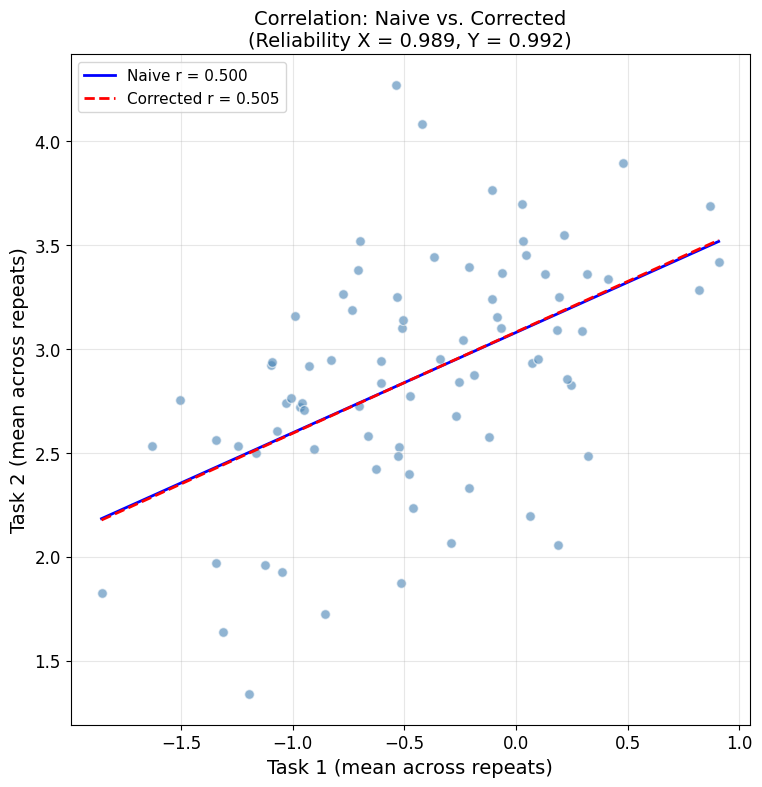

In [18]:
# Visualize the correlation with reliability information
fig = plot_scatter_with_reliability(
    x=demo_data['task1_mean'].values,
    y=demo_data['task2_mean'].values,
    reliability_x=result.reliability_x,
    reliability_y=result.reliability_y,
    naive_r=result.naive_r,
    corrected_r=result.corrected_r,
    xlabel='Task 1 (mean across repeats)',
    ylabel='Task 2 (mean across repeats)'
)
plt.show()

---

# Part 2: Planning Future Studies

Use this workflow to determine optimal sample sizes and measurement protocols.

In [43]:
# Define expected parameters for your planned study
planned_task1 = TaskParameters(
    between_var=0.35,
    within_var=0.14,
    mean=0.0,
    name='task1'
)

planned_task2 = TaskParameters(
    between_var=0.45,
    within_var=0.05,
    mean=0.0,
    name='task2'
)

true_correlation = 0.5
n_subjects = 60
n_repeats = 2

print(f"Task 1 theoretical reliability: {planned_task1.reliability:.3f}")
print(f"Task 2 theoretical reliability: {planned_task2.reliability:.3f}")
print(f"Expected attenuation factor: {np.sqrt(planned_task1.reliability * planned_task2.reliability):.3f}")

Task 1 theoretical reliability: 0.714
Task 2 theoretical reliability: 0.900
Expected attenuation factor: 0.802


In [44]:
# Run simulation for a specific design
sim_result = run_simulation(
    planned_task1, planned_task2,
    n_subjects=n_subjects,
    n_repeats=n_repeats,
    true_correlation=true_correlation,
    n_iterations=1000,
    random_state=42
)

print(sim_result)

Simulation Results (N=60, repeats=2)
True correlation: 0.5000
Iterations: 1000

Naive Estimator:
  Mean: 0.4455  SD: 0.1036
  RMSE: 0.1170  95% CI: [0.228, 0.635]

Corrected Estimator:
  Mean: 0.4944  SD: 0.1130
  RMSE: 0.1131  95% CI: [0.256, 0.699]

Recommended estimator: Corrected



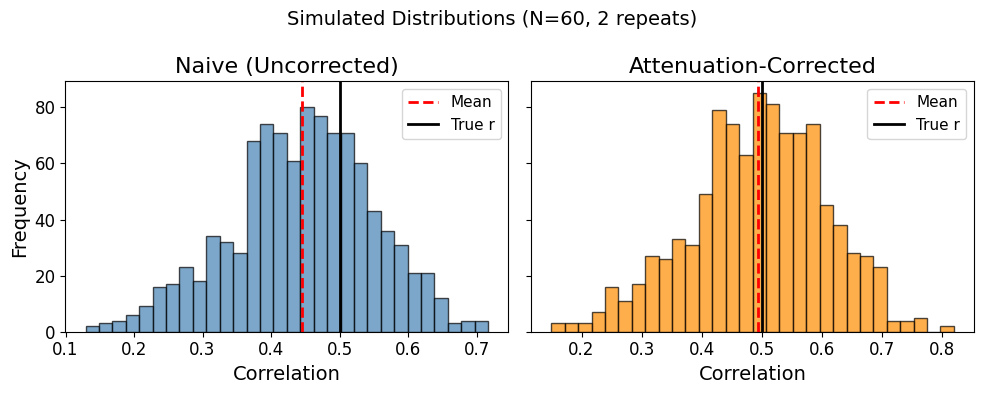

In [45]:
# Get distributions for visualization
distributions = get_simulation_distributions(
    planned_task1, planned_task2,
    n_subjects=n_subjects,
    n_repeats=n_repeats,
    true_correlation=true_correlation,
    n_iterations=1000,
    random_state=42
)

fig = plot_correlation_histograms(
    distributions['naive'],
    distributions['corrected'],
    true_correlation=true_correlation,
    title=f'Simulated Distributions (N={n_subjects}, {n_repeats} repeats)'
)
plt.show()

In [46]:
# Run grid search over design parameters
grid_results = run_simulation_grid(
    planned_task1, planned_task2,
    sample_sizes=[15, 30, 60, 120, 240],
    n_repeats_list=[2, 4, 6],
    true_correlation=true_correlation,
    n_iterations=500,
    random_state=42
)

print("\nSimulation Grid Results:")
grid_results.round(3)

Running condition 1/15: N=15, repeats=2
Running condition 2/15: N=15, repeats=4
Running condition 3/15: N=15, repeats=6
Running condition 4/15: N=30, repeats=2
Running condition 5/15: N=30, repeats=4
Running condition 6/15: N=30, repeats=6
Running condition 7/15: N=60, repeats=2
Running condition 8/15: N=60, repeats=4
Running condition 9/15: N=60, repeats=6
Running condition 10/15: N=120, repeats=2
Running condition 11/15: N=120, repeats=4
Running condition 12/15: N=120, repeats=6
Running condition 13/15: N=240, repeats=2
Running condition 14/15: N=240, repeats=4
Running condition 15/15: N=240, repeats=6

Simulation Grid Results:


,n_subjects,n_repeats,true_correlation,naive_mean,naive_sd,naive_rmse,naive_ci_lower,naive_ci_upper,corrected_mean,corrected_sd,corrected_rmse,corrected_ci_lower,corrected_ci_upper,recommended
0,15,2,0.5,0.432,0.226,0.236,-0.075,0.773,0.482,0.250,0.251,-0.088,0.879,Naive (uncorrected)
1,15,4,0.5,0.456,0.221,0.225,-0.084,0.799,0.483,0.232,0.233,-0.093,0.852,Naive (uncorrected)
2,15,6,0.5,0.462,0.214,0.217,0.004,0.796,0.482,0.222,0.223,0.004,0.823,Naive (uncorrected)
3,30,2,0.5,0.443,0.147,0.158,0.115,0.696,0.493,0.161,0.161,0.130,0.759,Naive (uncorrected)
4,30,4,0.5,0.457,0.147,0.153,0.127,0.695,0.486,0.155,0.155,0.136,0.743,Naive (uncorrected)
5,30,6,0.5,0.467,0.153,0.156,0.128,0.722,0.487,0.158,0.159,0.134,0.744,Naive (uncorrected)
6,60,2,0.5,0.442,0.108,0.122,0.219,0.632,0.492,0.119,0.119,0.244,0.706,Corrected
7,60,4,0.5,0.469,0.105,0.109,0.264,0.668,0.497,0.109,0.110,0.282,0.705,Naive (uncorrected)
8,60,6,0.5,0.467,0.100,0.105,0.257,0.643,0.486,0.103,0.104,0.269,0.668,Corrected
9,120,2,0.5,0.444,0.071,0.090,0.308,0.586,0.493,0.077,0.077,0.346,0.644,Corrected


/Users/annabruns/Downloads/attenuation_toolbox/visualization.py:500: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_numeric = pivot.applymap(lambda x: 1 if 'Corrected' in str(x) else 0)


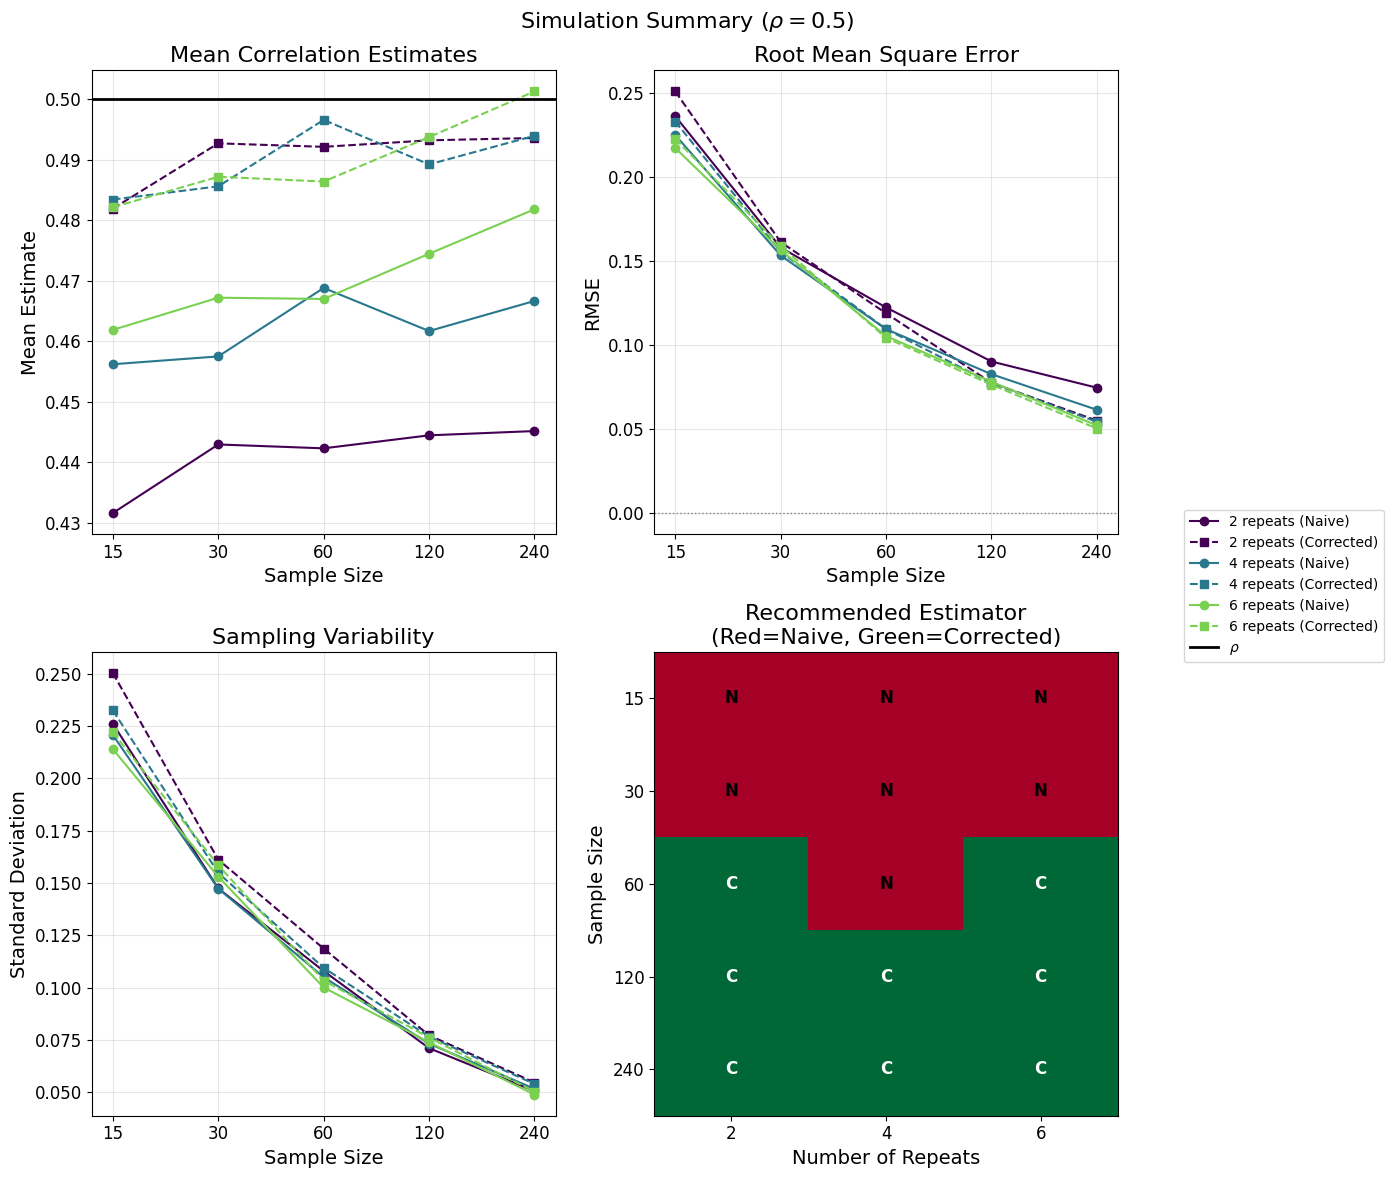

In [47]:
# Comprehensive summary plot
fig = plot_simulation_summary(grid_results, true_correlation=true_correlation)
plt.show()

---

# Summary

## Key Functions

| Function | Use Case |
|----------|----------|
| `analyze_correlation()` | Analyze single pair of tasks |
| `analyze_all_pairs()` | Analyze all pairwise correlations |
| `run_simulation()` | Evaluate estimators for specific design |
| `run_simulation_grid()` | Compare across multiple designs |
| `plot_correlation_heatmaps()` | Visualize naive vs. corrected |
| `plot_simulation_summary()` | Comprehensive simulation results |